<a href="https://colab.research.google.com/github/ShivinM-17/Land-cover-segementation-using-UNet/blob/main/Land_cover_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Land Cover classification using satellite images and deep learning

### Downloading the dataset

#### Setting up the kaggle directory for downloading

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivinmangal","key":"ce4ee28e120d6bac07cad9bbe92c459e"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                  title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows               Netflix Movies and TV Shows                      1MB  2024-04-10 09:48:38           5249        110  1.0              
sahirmaharajj/youth-tobacco-survey                   Youth Tobacco Dataset (2 Decades)              264KB  2024-04-11 20:19:31           1120         23  1.0              
alistairking/u-s-co2-emissions                       CO2 Emissions (in U.S.)                        546KB  2024-04-20 21:22:34            558         25  1.0              
mexwell/heart-disease-dataset                        🫀 Heart Disease Dataset                        399KB  2024-04-08 09:43:49           278

In [ ]:
# Now, downloading the dataset
!kaggle datasets download -d adrianboguszewski/landcoverai

100% 1.43G/1.43G [00:16<00:00, 113MB/s]
100% 1.43G/1.43G [00:16<00:00, 95.0MB/s]


### Setting up the dataset

In [ ]:
import shutil
import os

# Define the paths
zip_file_path = '/content/landcoverai.zip'
destination_folder = '/content/data/'

# Check if the destination folder exists, if not create it
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Move the zip file to the destination folder
shutil.move(zip_file_path, destination_folder)

'/content/data/landcoverai.zip'

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "landcoverdata"

# Print the type of image_path
print(f"Type of image_path: {type(image_path)}")

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exists ... skipping download")
elif image_path.is_file():
    print(f"{image_path} exists as a file ... removing it and creating a directory")
    image_path.unlink()
    image_path.mkdir(parents=True, exist_ok=True)
else:
    print(f"{image_path} does not exist ... creating one")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip landcoverai data
with zipfile.ZipFile(data_path / "landcoverai.zip", "r") as zip_ref:
    print("Unzipping landcoverai data....")
    zip_ref.extractall(image_path)


Type of image_path: <class 'pathlib.PosixPath'>
data/landcoverdata does not exist ... creating one
Unzipping landcoverai data....


In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 4 images in 'data/landcoverdata'
There are 0 directories and 41 images in 'data/landcoverdata/images'
There are 0 directories and 41 images in 'data/landcoverdata/masks'


#### Visualising the data


In [ ]:
import random
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import PosixPath

In [ ]:
# Function to plot random images
def plot_image(image_path_list):
  # Choose a random image to visualize
  random_image_path = random.choice(image_path_list)

  # Getting the mask path for the same image
  random_mask_path = PosixPath(str(random_image_path).replace("images", "masks"))

  print(random_image_path)
  print(random_mask_path)

  # Now, read the image and the mask
  temp_img = cv2.imread(str(random_image_path), 1)
  temp_mask = cv2.imread(str(random_mask_path))

  # Since the format of image is normally in BGR format, convert it to RGB format
  temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
  classes, count = np.unique(temp_mask[:,:,0], return_counts=True) # Visualize only one channel. All chanels are identical.

  # Get the shape of the image
  print("Image shape: ", temp_img.shape)
  print("Mask shape: ", temp_mask[:,:,0].shape)
  print("Classes are: ", classes, " and the counts are: ", count)

  ## Now, plotting the images
  # Plot image with one color channel
  plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.imshow(temp_img[:,:,0])
  plt.title("One channel of image")

  # Plot image with all color channels
  plt.subplot(1, 2, 2)
  plt.imshow(temp_img)
  plt.title("All channels of image")
  plt.show()

  # Plot the mask of the image
  plt.figure(figsize=(6,4))
  plt.imshow(temp_mask[:,:,0])
  plt.title("Mask")
  plt.show()

data/landcoverdata/images/M-34-6-A-d-2-2.tif
data/landcoverdata/masks/M-34-6-A-d-2-2.tif
Image shape:  (9470, 8818, 3)
Mask shape:  (9470, 8818)
Classes are:  [0 1 2 3 4]  and the counts are:  [68643142  1467062 10910421   236301  2249534]


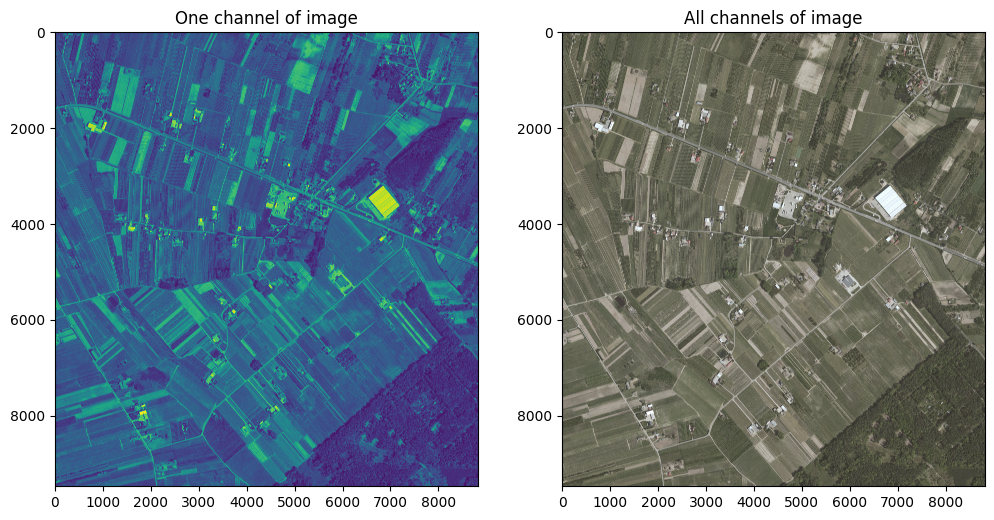

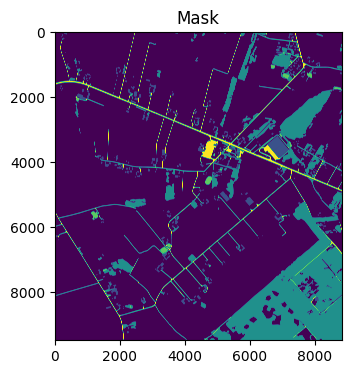

In [ ]:
image_path_list = list(image_path.glob("images/*.tif"))
plot_image(image_path_list)

####Creating patches of images

Since, each of the image covers a large area, and the count of images in our dataset is just 41, there is a need for increasing the data, so as to create appropriate amount of data to create training and testing set.

Therefore, we will be patchifying the images, which will cover smaller scales of areas.

This will also be used for the masked images.

In [ ]:
!pip install -q patchify

In [ ]:
# Patching the images
from patchify import patchify
from PIL import Image

root_directory = "/content/data/landcoverdata"

img_dir = os.path.join(root_directory, "images")
mask_dir = os.path.join(root_directory, "masks")

patch_size = 256

# Create a directory for patches of images from image path
patches_img_dir = os.path.join(f"patches_{patch_size}", "images")
patches_img_dir = os.path.join(root_directory, patches_img_dir)
os.makedirs(patches_img_dir, exist_ok=True)

# Create a directory for patches of masks from mask path
patches_mask_dir = os.path.join(f"patches_{patch_size}", "masks")
patches_mask_dir = os.path.join(root_directory, patches_mask_dir)
os.makedirs(patches_mask_dir, exist_ok=True)

In [ ]:
def patching(data_dir, patches_dir, patch_size):
  for filename in os.listdir(data_dir):
    if filename.endswith('.tif'):
      img = cv2.imread(os.path.join(data_dir, filename), 1)
      max_height = (img.shape[0] // patch_size) * patch_size
      max_width = (img.shape[1] // patch_size) * patch_size
      img = img[0:max_height, 0:max_width]
      print(f"Patchifying {filename}...")
      patches = patchify(img, (patch_size, patch_size, 3), step = patch_size)  # non-overlapping
      print("Patches shape:", patches.shape)
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          single_patch = patches[i, j, 0, :, :] # the 0 is an extra unncessary dimension added by patchify for multiple channels scenario
          cv2.imwrite(os.path.join(patches_dir, filename.replace(".tif", f"_patch_{i}_{j}.tif")), single_patch)

In [ ]:
print("Dividing images into patches...")
patching(img_dir, patches_img_dir, patch_size)
print("Dividing images into patches completed successfull!")

Dividing images into patches...
Patchifying M-34-65-D-c-4-2.tif...
Patches shape: (36, 35, 1, 256, 256, 3)
Patchifying M-33-48-A-c-4-4.tif...
Patches shape: (36, 35, 1, 256, 256, 3)
Patchifying N-33-130-A-d-3-3.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying N-34-106-A-b-3-4.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying M-34-56-A-b-1-4.tif...
Patches shape: (37, 35, 1, 256, 256, 3)
Patchifying N-34-140-A-b-3-2.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying N-33-139-C-d-2-2.tif...
Patches shape: (37, 35, 1, 256, 256, 3)
Patchifying N-34-140-A-d-3-4.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying N-34-66-C-c-4-3.tif...
Patches shape: (18, 16, 1, 256, 256, 3)
Patchifying M-34-55-B-b-4-1.tif...
Patches shape: (37, 35, 1, 256, 256, 3)
Patchifying N-34-97-C-b-1-2.tif...
Patches shape: (18, 16, 1, 256, 256, 3)
Patchifying M-34-51-C-b-2-1.tif...
Patches shape: (36, 34, 1, 256, 256, 3)
Patchifying N-34-94-A-b-2-4.tif...
Patches shape: (37, 34, 1, 2

In [ ]:
print("Dividing masks into patches...")
patching(mask_dir, patches_mask_dir, patch_size)
print("Dividing masks into patches completed successfull!")

Dividing masks into patches...
Patchifying M-34-65-D-c-4-2.tif...
Patches shape: (36, 35, 1, 256, 256, 3)
Patchifying M-33-48-A-c-4-4.tif...
Patches shape: (36, 35, 1, 256, 256, 3)
Patchifying N-33-130-A-d-3-3.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying N-34-106-A-b-3-4.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying M-34-56-A-b-1-4.tif...
Patches shape: (37, 35, 1, 256, 256, 3)
Patchifying N-34-140-A-b-3-2.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying N-33-139-C-d-2-2.tif...
Patches shape: (37, 35, 1, 256, 256, 3)
Patchifying N-34-140-A-d-3-4.tif...
Patches shape: (37, 34, 1, 256, 256, 3)
Patchifying N-34-66-C-c-4-3.tif...
Patches shape: (18, 16, 1, 256, 256, 3)
Patchifying M-34-55-B-b-4-1.tif...
Patches shape: (37, 35, 1, 256, 256, 3)
Patchifying N-34-97-C-b-1-2.tif...
Patches shape: (18, 16, 1, 256, 256, 3)
Patchifying M-34-51-C-b-2-1.tif...
Patches shape: (36, 34, 1, 256, 256, 3)
Patchifying N-34-94-A-b-2-4.tif...
Patches shape: (37, 34, 1, 25

In [ ]:
# Check the count of new images and masks in the patch directory
print(f"Count of patchified images: {len(os.listdir(patches_img_dir))}")
print(f"Count of patchified masks: {len(os.listdir(patches_mask_dir))}")

Count of patchified images: 23143
Count of patchified masks: 23143


In [ ]:
def discard_useless_patches(patches_img_dir, patches_mask_dir):
  for filename in os.listdir(patches_mask_dir):
    img_path = os.path.join(patches_img_dir, filename)
    mask_path = os.path.join(patches_mask_dir, filename)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    classes, count = np.unique(mask, return_counts = True)
    # If background class occupies more than 95% of the image, discard the image and mask
    if (count[0] / count.sum()) > 0.95:
      os.remove(img_path)
      os.remove(mask_path)

In [ ]:
discard_useless_patches(patches_img_dir, patches_mask_dir)

In [ ]:
# Check the count of new images and masks in the patch directory
print(f"Count of patchified images: {len(os.listdir(patches_img_dir))}")
print(f"Count of patchified masks: {len(os.listdir(patches_mask_dir))}")

Count of patchified images: 23143
Count of patchified masks: 23143


In [ ]:
patches_img_dir, patches_mask_dir

('/content/data/landcoverdata/patches_256/images',
 '/content/data/landcoverdata/patches_256/masks')

##### Randomnly plotting the patched images

/content/data/landcoverdata/patches_256/images/M-33-20-D-c-4-2_patch_28_17.tif
/content/data/landcoverdata/patches_256/masks/M-33-20-D-c-4-2_patch_28_17.tif
Image shape:  (256, 256, 3)
Mask shape:  (256, 256)
Classes are:  [0 2]  and the counts are:  [51360 14176]


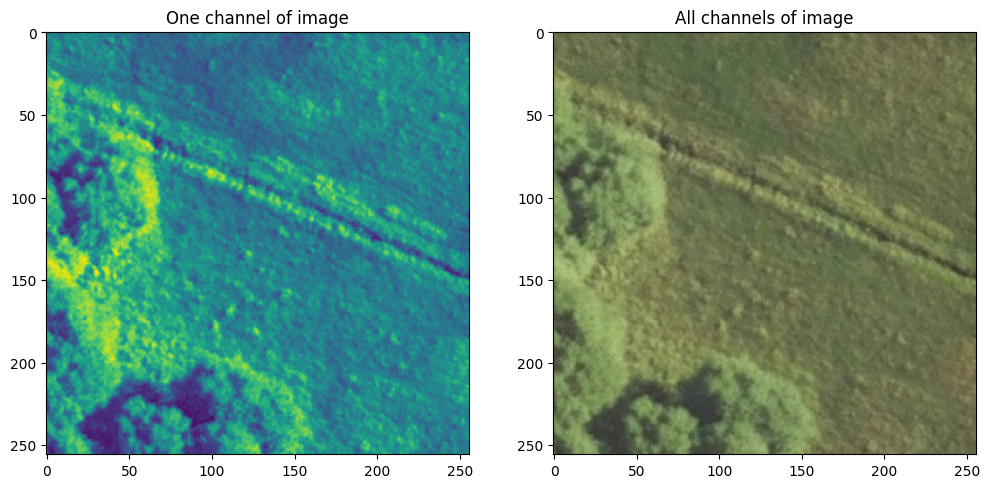

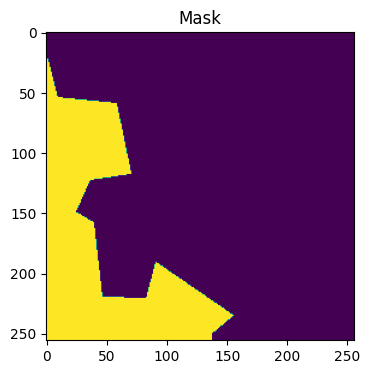

In [ ]:
# Get all image path
image_path_list = list(PosixPath(patches_img_dir).glob("*.tif"))
plot_image(image_path_list)

#### Creating training and validation dataset directories

In [ ]:
!pip install -q split_folders

In [ ]:
# Split the patches into different folders
import splitfolders

input_folder = patches_img_dir.strip("images")
print(input_folder)
output_folder = os.path.join(root_directory, "train_val_test")
print(output_folder)

/content/data/landcoverdata/patches_256/
/content/data/landcoverdata/train_val_test


In [ ]:
# Create the folder for the output folder path
os.makedirs(output_folder, exist_ok=True)

In [ ]:
# Now, we have to create train and validation sets of the data
# We will split the accordingly with a ratio of 8:2, wherein 80% of the data
# will be used for training and the remaining 20% will be used for validation

splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.8, .2), group_prefix=None,
                   move=False) # splitting in training and validation only

Copying files: 46286 files [01:01, 756.95 files/s] 


In [ ]:
# Get the train and validation directory paths
train_dir = os.path.join(output_folder, "train")
val_dir = os.path.join(output_folder, "val")

In [ ]:
# Check the directory and its components
walk_through_dir(train_dir)
print()
walk_through_dir(val_dir)

There are 2 directories and 0 images in '/content/data/landcoverdata/train_val_test/train'
There are 0 directories and 18514 images in '/content/data/landcoverdata/train_val_test/train/images'
There are 0 directories and 18514 images in '/content/data/landcoverdata/train_val_test/train/masks'

There are 2 directories and 0 images in '/content/data/landcoverdata/train_val_test/val'
There are 0 directories and 4629 images in '/content/data/landcoverdata/train_val_test/val/images'
There are 0 directories and 4629 images in '/content/data/landcoverdata/train_val_test/val/masks'


In [ ]:
x_train_dir = os.path.join(train_dir, "images")
y_train_dir = os.path.join(train_dir, "masks")

x_val_dir = os.path.join(val_dir, "images")
y_val_dir = os.path.join(val_dir, "masks")

In [ ]:
x_train_dir, y_train_dir

('/content/data/landcoverdata/train_val_test/train/images',
 '/content/data/landcoverdata/train_val_test/train/masks')

In [ ]:
x_val_dir, y_val_dir

('/content/data/landcoverdata/train_val_test/val/images',
 '/content/data/landcoverdata/train_val_test/val/masks')

### Creating Custom dataset for train and test directories

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
import albumentations as album

In [ ]:
# Create a dataset class (subclass torch.utils.data.Dataset)
class LandCoverDataset(Dataset):

  # Set the classes
  CLASSES = ['background', 'building', 'woodland', 'water', 'road']

  # Initialise the class
  def __init__(self,
               image_path: str,
               mask_path:str,
               classes = None,
               augmentations = None,
               transforms:list=None):

    self.ids = os.listdir(image_path)
    self.images = [os.path.join(image_path, id) for id in self.ids]
    self.masks = [os.path.join(mask_path, id) for id in self.ids]

    # convert str names to class values on masks
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

    self.transforms = transforms
    self.augmentations = augmentations

  # Function to get items from it
  def __getitem__(self, i):
    # Read data
    image = cv2.imread(self.images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    mask = cv2.imread(self.masks[i], 0)

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in self.class_values]
    mask = np.stack(masks, axis=-1).astype('float32')

    # Applying the augmentations to the image and mask
    if self.augmentations:
      sample = self.augmentations(image=image, mask = mask)
      image, mask = sample['image'], sample['mask']

    # apply transforms
    if self.transforms:
        image = self.transforms[0](image)
        mask = self.transforms[1](mask)

    return image, mask

  # Function to get total count of images in the dataset
  def __len__(self):
    return len(self.ids)

In [ ]:
# Create functions for augmentations and preprocessing
def to_tensor(x, **kwargs):
  return x.transpose(2, 0, 1).astype("float32")

def training_augs():
  transforms = [
      album.HorizontalFlip(p=0.5),
      album.VerticalFlip(p=0.5),
      album.Perspective(p=0.5),
  ]
  return album.Compose(transforms)

def preprocess(preprocess_fn):
  return album.transpose([album.Lambda(image=to_tensor, mask=to_tensor), album.Lambda(image=preprocess_fn)])

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

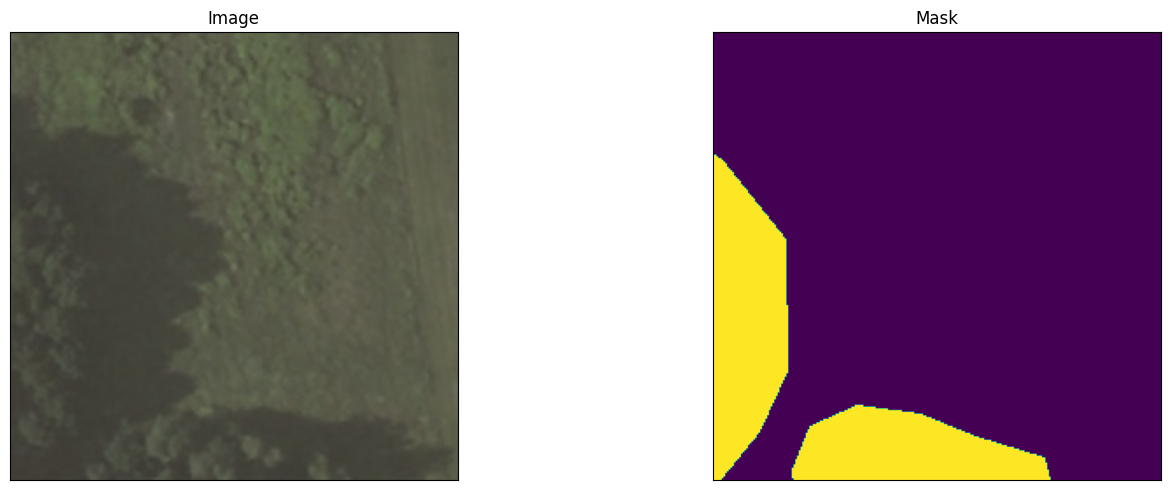

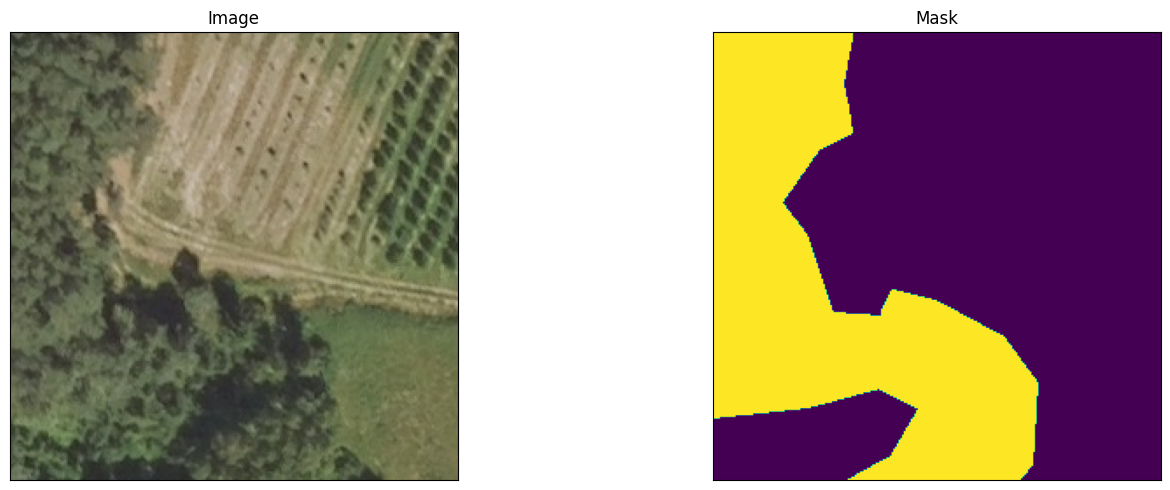

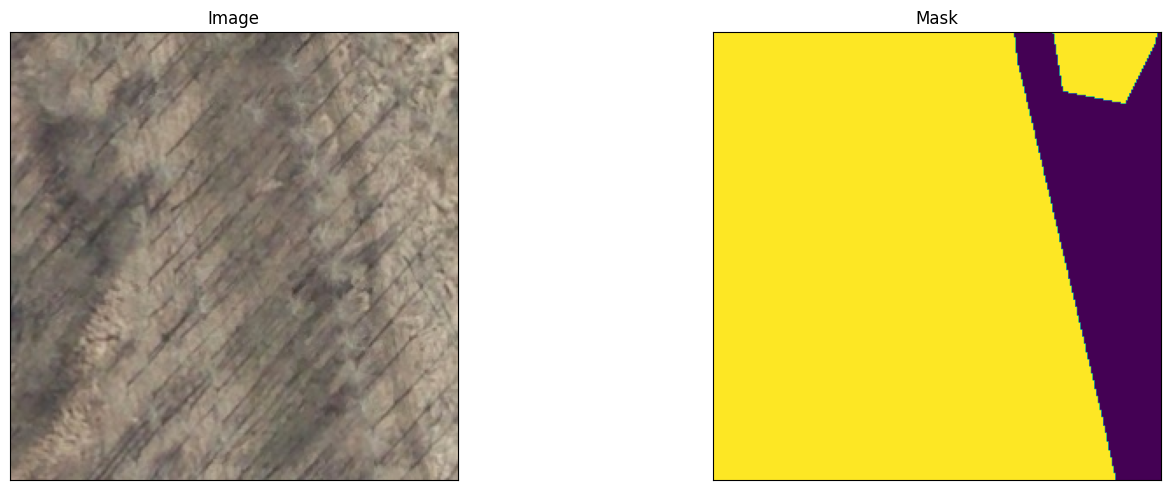

In [ ]:
# Visualize resulted augmented images and masks
augmented_dataset = LandCoverDataset(
    image_path = x_train_dir,
    mask_path = y_train_dir,
    augmentations=training_augs(),
    classes=['background', 'building', 'woodland', 'water', 'road'],
)

# Same image with different random transforms
for i in range(3):
  idx = random.randint(1, len(augmented_dataset))
  image, mask = augmented_dataset[idx]
  visualize(image=image, mask=np.argmax(mask, axis=2))

In [ ]:
# Check out the shapes of the image and mask
print(f"Shape of the image: {image.shape}")
print(f"Shape of the mask: {mask.shape}")

Shape of the image: (256, 256, 3)
Shape of the mask: (256, 256, 5)


In [ ]:
from torchvision import transforms

# Create the transforms for the data, to normalize it for the model
transforms_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]  # imagenet parameters
    )
])

transforms_2 = transforms.Compose([transforms.ToTensor()])

In [ ]:
# Now, create the test and train dataset
train_dataset = LandCoverDataset(
    image_path = x_train_dir,
    mask_path = y_train_dir,
    transforms = [transforms_1, transforms_2],
    classes=['background', 'building', 'woodland', 'water', 'road'],
)

val_dataset = LandCoverDataset(
    image_path = x_val_dir,
    mask_path = y_val_dir,
    transforms = [transforms_1, transforms_2],
    classes=['background', 'building', 'woodland', 'water', 'road'],
)

In [ ]:
# Check the length of the train and test data
len(train_dataset), len(val_dataset)

(18514, 4629)

#### Now, turning the dataset into a DataLoader

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

# Create the dataloader
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            num_workers = NUM_WORKERS,
                            shuffle = False)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d35383cf2e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d35383cf340>)

In [ ]:
# Get image and label from LandCoverDataset
img_sample, mask_sample = next(iter(train_dataloader))

# Print out the shapes
img_sample.shape, mask_sample.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([8, 3, 256, 256]), torch.Size([8, 5, 256, 256]))

### Creating the models for the data

### Setting up train and test procedures for the model

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Create train and test loops function to train the overall model

* `train_step()` - takes in a model and a dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
import torch.nn.functional as F

# Function to calculate dice loss
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

# Function to calculate the loss functions
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [ ]:
# Function to print the metrics
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}\n".format(phase, ", ".join(outputs)))

In [ ]:
import time
import copy
from collections import defaultdict
from tqdm import tqdm

def train_model(model, dataloaders, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    metrics_history_train = []
    metrics_history_val = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    if scheduler is not None:
                        scheduler.step()  # Move lr_scheduler.step() here after optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase=="train":
              metrics_history_train.append(metrics)
            if phase=="val":
              metrics_history_val.append(metrics)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    metrics_history = {"train": metrics_history_train,
                       "val": metrics_history_val}

    return model, metrics_history


### Creating the models for the data

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torchvision.transforms.functional

In [ ]:
# Creating a class for 2 CNNs connected together with ReLU as well
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
# class for creating the max-pool 2d layers to down-sample the data
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
# class for creating the ConvTranspose2d layers to up-sample the data
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x.float())
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
# Instantiate the model
torch.manual_seed(42)

# Get the classes
CLASSES = ['bac kground', 'building', 'woodland', 'water', 'road']

model = UNet(n_channels = 3, n_classes = len(CLASSES))
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
from torch.optim import lr_scheduler

# Set the optimizer and the learning rate scheduler for the model
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,
                              model.parameters()),
                             lr = 1e-3)

# Setting the learning rate scheduler
lr_scheduler_md = lr_scheduler.StepLR(optimizer, step_size=15, gamma = 0.1)

### Now, training the model

#### Set the model and data to the device

In [ ]:
# Set the device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model to the device
model = model.to(device)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Create the dictionary for the dataloader
data_dict = {'train': train_dataloader,
             'val': val_dataloader}

model, model_metric_history = train_model(model = model,
                                          dataloaders = data_dict,
                                          optimizer = optimizer,
                                          scheduler = None,
                                          num_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------
LR 0.001
train: bce: 0.270032, dice: 0.658137, loss: 0.464084



 10%|█         | 1/10 [17:33<2:38:04, 1053.78s/it]

val: bce: 0.220358, dice: 0.556312, loss: 0.388335

saving best model
17m 34s
Epoch 1/9
----------
LR 0.001
train: bce: 0.221376, dice: 0.547746, loss: 0.384561



 20%|██        | 2/10 [35:05<2:20:18, 1052.35s/it]

val: bce: 0.180618, dice: 0.519503, loss: 0.350060

saving best model
17m 31s
Epoch 2/9
----------
LR 0.001
train: bce: 0.231034, dice: 0.420049, loss: 0.325541



 30%|███       | 3/10 [52:37<2:02:46, 1052.35s/it]

val: bce: 0.234097, dice: 0.275604, loss: 0.254851

saving best model
17m 32s
Epoch 3/9
----------
LR 0.001
train: bce: 0.235362, dice: 0.290646, loss: 0.263004



 40%|████      | 4/10 [1:10:09<1:45:12, 1052.09s/it]

val: bce: 0.208136, dice: 0.258106, loss: 0.233121

saving best model
17m 32s
Epoch 4/9
----------
LR 0.001
train: bce: 0.216031, dice: 0.271568, loss: 0.243800



 50%|█████     | 5/10 [1:27:40<1:27:39, 1051.83s/it]

val: bce: 0.185101, dice: 0.272455, loss: 0.228778

saving best model
17m 31s
Epoch 5/9
----------
LR 0.001
train: bce: 0.204012, dice: 0.261786, loss: 0.232899



 60%|██████    | 6/10 [1:45:13<1:10:08, 1052.06s/it]

val: bce: 0.202721, dice: 0.285185, loss: 0.243953

17m 33s
Epoch 6/9
----------
LR 0.001
train: bce: 0.195908, dice: 0.251069, loss: 0.223489



 70%|███████   | 7/10 [2:02:45<52:36, 1052.13s/it]  

val: bce: 0.167722, dice: 0.249439, loss: 0.208581

saving best model
17m 32s
Epoch 7/9
----------
LR 0.001
train: bce: 0.187451, dice: 0.246862, loss: 0.217157



 80%|████████  | 8/10 [2:20:17<35:04, 1052.07s/it]

val: bce: 0.170020, dice: 0.252967, loss: 0.211493

17m 32s
Epoch 8/9
----------
LR 0.001
train: bce: 0.178078, dice: 0.235846, loss: 0.206962



 90%|█████████ | 9/10 [2:37:48<17:31, 1051.72s/it]

val: bce: 0.165468, dice: 0.223511, loss: 0.194490

saving best model
17m 31s
Epoch 9/9
----------
LR 0.001
train: bce: 0.178796, dice: 0.224245, loss: 0.201521



100%|██████████| 10/10 [2:55:19<00:00, 1051.95s/it]

val: bce: 0.150556, dice: 0.224080, loss: 0.187318

saving best model
17m 31s
Best val loss: 0.187318


### Save the model's trained parameters

In [ ]:
torch.save(model, "model_data.pt")

In [ ]:
from google.colab import files
files.download('model_data.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualizing the evaluation metric history of the model

In [ ]:
# Get all the different metrics in individual list (training metrics)
bce_lst_train = []
dice_lst_train = []
loss_lst_train = []

for metric_dict in model_metric_history['train']:
  bce_lst_train.append(metric_dict["bce"])
  dice_lst_train.append(metric_dict["dice"])
  loss_lst_train.append(metric_dict["loss"])

In [ ]:
# Get all the different metrics in individual list (validation metrics)
bce_lst_val = []
dice_lst_val = []
loss_lst_val = []

for metric_dict in model_metric_history['val']:
  bce_lst_val.append(metric_dict["bce"])
  dice_lst_val.append(metric_dict["dice"])
  loss_lst_val.append(metric_dict["loss"])

#### Plotting the evaluation metrics curves

In [ ]:
def plot_loss_curves(train_res: list, val_res: list):
  """
  Plots training curves of a train and validation metric results
  """
  # Get the loss values of the results dictionary (training and test)
  bce_train = train_res[0]
  dice_train = train_res[1]
  loss_train = train_res[2]

  bce_val = val_res[0]
  dice_val = val_res[1]
  loss_val = val_res[2]

  # Figure out number of epochs present
  epochs = range(len(bce_train))

  # Setup a plot
  plt.figure(figsize=(15, 6))

  # Plot the BCE
  plt.subplot(1, 3, 1)
  plt.plot(epochs, bce_train, label="train_bce")
  plt.plot(epochs, bce_val, label = "val_bce")
  plt.title("Binary cross entropy score curves of the model")
  plt.xlabel("Epochs")
  plt.ylabel("BCE")
  plt.legend()

  # Plot the Dice score
  plt.subplot(1, 3, 2)
  plt.plot(epochs, dice_train, label = 'train_dice')
  plt.plot(epochs, dice_val, label = 'val_dice')
  plt.title("Dice score curve of the model")
  plt.xlabel("Epochs")
  plt.ylabel("Dice Score")
  plt.legend();

  # Plot the loss
  plt.subplot(1, 3, 3)
  plt.plot(epochs, loss_train, label = 'train_loss')
  plt.plot(epochs, loss_val, label = 'val_loss')
  plt.title("Loss curves of the model")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend();
  plt.tight_layout();

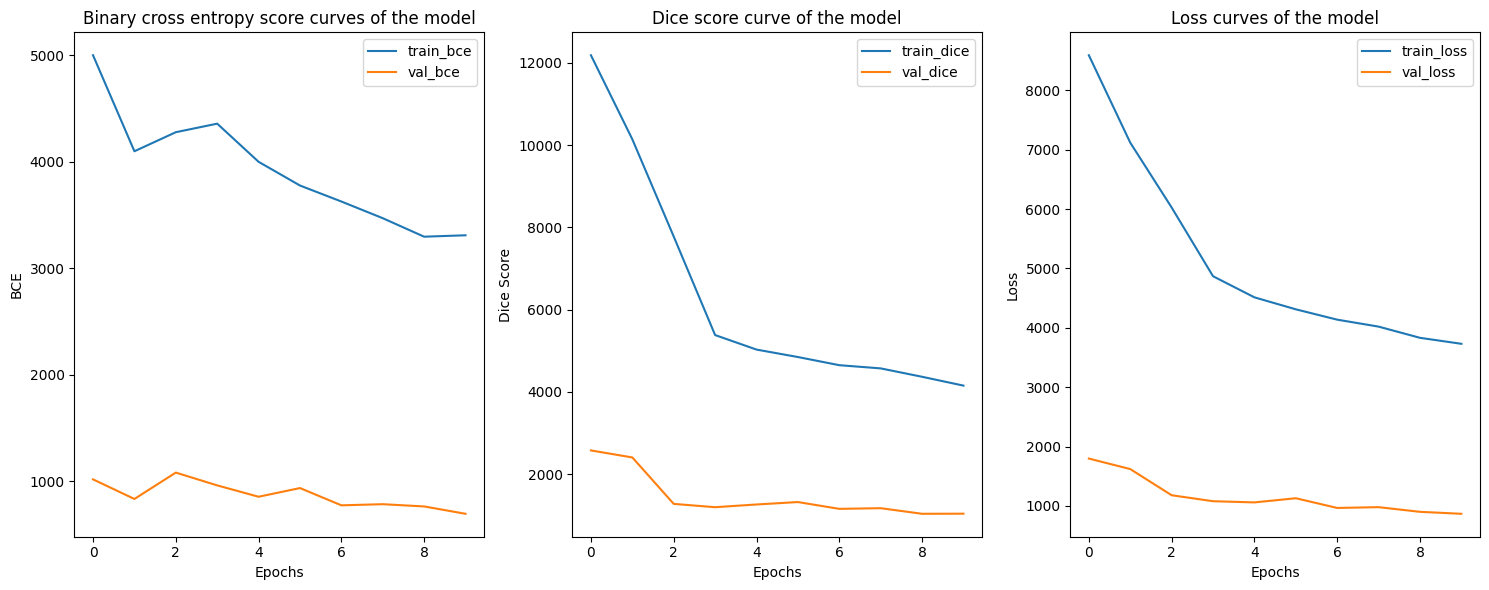

In [ ]:
# Now, plot the loss curves
plot_loss_curves([bce_lst_train, dice_lst_train, loss_lst_train], [bce_lst_val, dice_lst_val, loss_lst_val])

### Predicting using the trained model

In [ ]:
# First, load the trained model
model = torch.load("/content/model_data.pt")
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
len(val_dataloader), len(train_dataloader)

(579, 2315)

In [ ]:
def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    ct = 0
    # Iterate over the dataset
    with torch.no_grad():
        for inputs, masks in tqdm(dataloader):  # Assuming each batch contains (inputs, labels)
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append((inputs.cpu().numpy(),
                                masks.cpu().numpy(),
                                outputs.cpu().numpy()))  # Append predictions to the list
            ct += 1
            if ct == 150: break

    return predictions

test_predictions = predict(model, val_dataloader, device)

 26%|██▌       | 149/579 [00:26<01:17,  5.56it/s]


In [ ]:
len(test_predictions[7]) ## tuple

3

In [ ]:
test_predictions[0][0][0].shape, test_predictions[0][1][0].shape

((3, 256, 256), (5, 256, 256))

In [ ]:
type(image)

numpy.ndarray

In [ ]:


idx = random.randint(1, len(test_predictions))
image, mask, pred_mask = test_predictions[idx][0][0], test_predictions[idx][1][0][0], test_predictions[idx][2][0][0]
image = np.transpose(image, (1, 2, 0))

In [ ]:
image.shape, mask.shape, pred_mask.shape

((256, 256, 3), (256, 256), (256, 256))

Text(0.5, 1.0, 'Predicted mask')

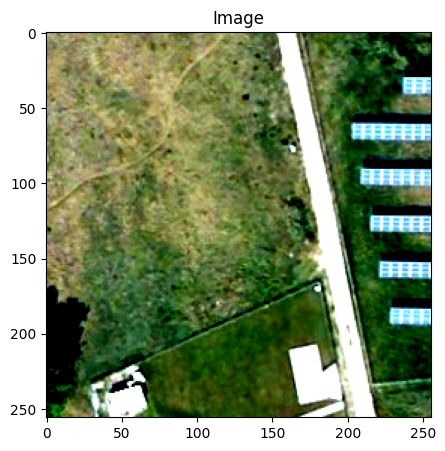

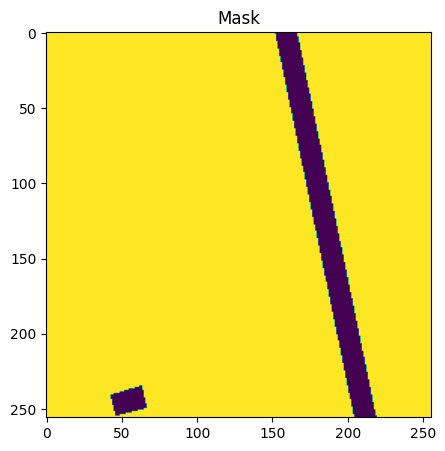

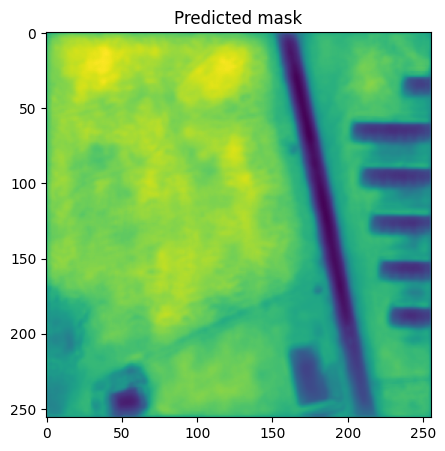

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title("Image")
plt.figure(figsize=(5, 5))
plt.imshow(mask)
plt.title("Mask")
plt.figure(figsize=(5, 5))
plt.imshow(pred_mask)
plt.title("Predicted mask")

In [ ]:
idx = random.randint(1, len(test_predictions))
image, mask, pred_mask = test_predictions[idx][0][0], test_predictions[idx][1][0][0], test_predictions[idx][2][0][0]
image = np.transpose(image, (1, 2, 0))

Text(0.5, 1.0, 'Predicted mask')

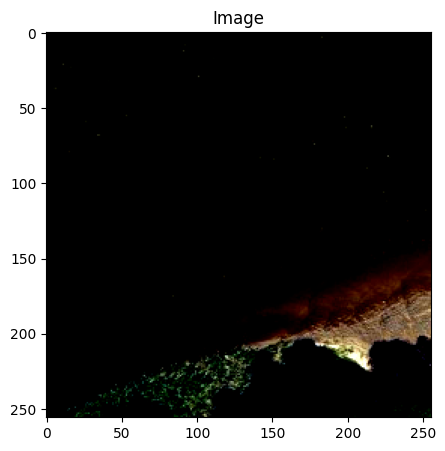

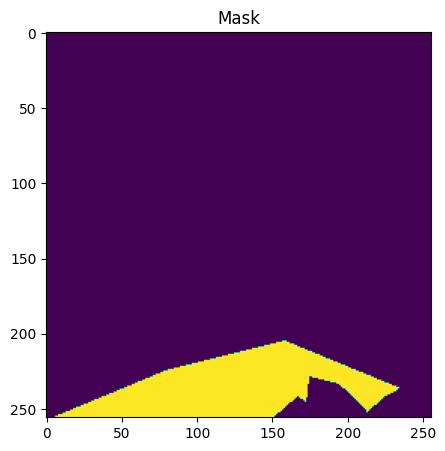

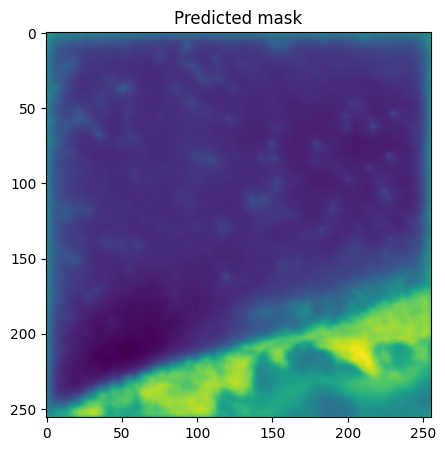

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title("Image")
plt.figure(figsize=(5, 5))
plt.imshow(mask)
plt.title("Mask")
plt.figure(figsize=(5, 5))
plt.imshow(pred_mask)
plt.title("Predicted mask")